In [113]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, log_loss
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import warnings 
warnings.filterwarnings("ignore")

In [114]:
os.chdir('../input/car-insurance-data/')

In [115]:
df = pd.read_csv('Car_Insurance_Claim.csv', index_col='ID')

# Задача : даны признаки клиентов, оформивших страховку на машину, нужно научиться предсказывать, понадобится ли клиенту выплатить страховку (1 - клиенту понадобилось выплатить страховку, 0 - иначе)

![](https://1gai.ru/uploads/cache/thumbs/750/0/7/750_0_07bcb6c167b0bfe8a670548557acf828.webp)

# Описание признаков
**RACE** - *принадлежность к рассовой группе: minority - раса меньшинств, majority - иначе*

**VEHICLE_OWNERSHIP** - *владение автомобилем (1/0 : владеет этой машиной/не владеет этой машиной)*

**POSTAL_CODE** - *почтовый индекс*

**SPEEDING_VIOLATIONS** - *количество нарушений скорости*

**DUIS** - *кол-во ДТП*

**PAST_ACCIDENTS** - *прошлые аварии (кол-во)*

**OUTCOME** - *1, если клиенту потребовалась страховка, 0 - иначе*

## Другие признаки(из названия понятна их суть)

#### 'AGE', 'GENDER', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME','CREDIT_SCORE', 'VEHICLE_YEAR', 'MARRIED', 'CHILDREN', 'ANNUAL_MILEAGE', 'VEHICLE_TYPE'

# Разбиение данных на train/test

In [116]:
X, X_test, _, __ = train_test_split(df, df['OUTCOME'], test_size=0.2, random_state=21)

### Тут я составил списки с категориальными и числовыми признаками(зависимую/целевую переменную я не отнесу к числовым, а оставля в стороне)
#### Сразу заметим, что почтовый индекс не может влиять на целевую переменную как количественный признак, поэтому я переведу этот признак в категориальный для дальнейшей обработки (даже корреляция между ним и таргетом примерно равна нулю)

In [117]:
X.corr().loc['POSTAL_CODE', 'OUTCOME']

0.10178197668965137

In [118]:
from_int_to_str = np.vectorize(lambda x: str(x))
X['POSTAL_CODE'] = from_int_to_str(X['POSTAL_CODE'])
X_test['POSTAL_CODE'] = from_int_to_str(X_test['POSTAL_CODE'])

In [119]:
cat_feats = [x for x in X.columns if X[x].dtype == 'object']
num_feats = [x for x in df.columns if X[x].dtype != 'object' and x != 'OUTCOME']

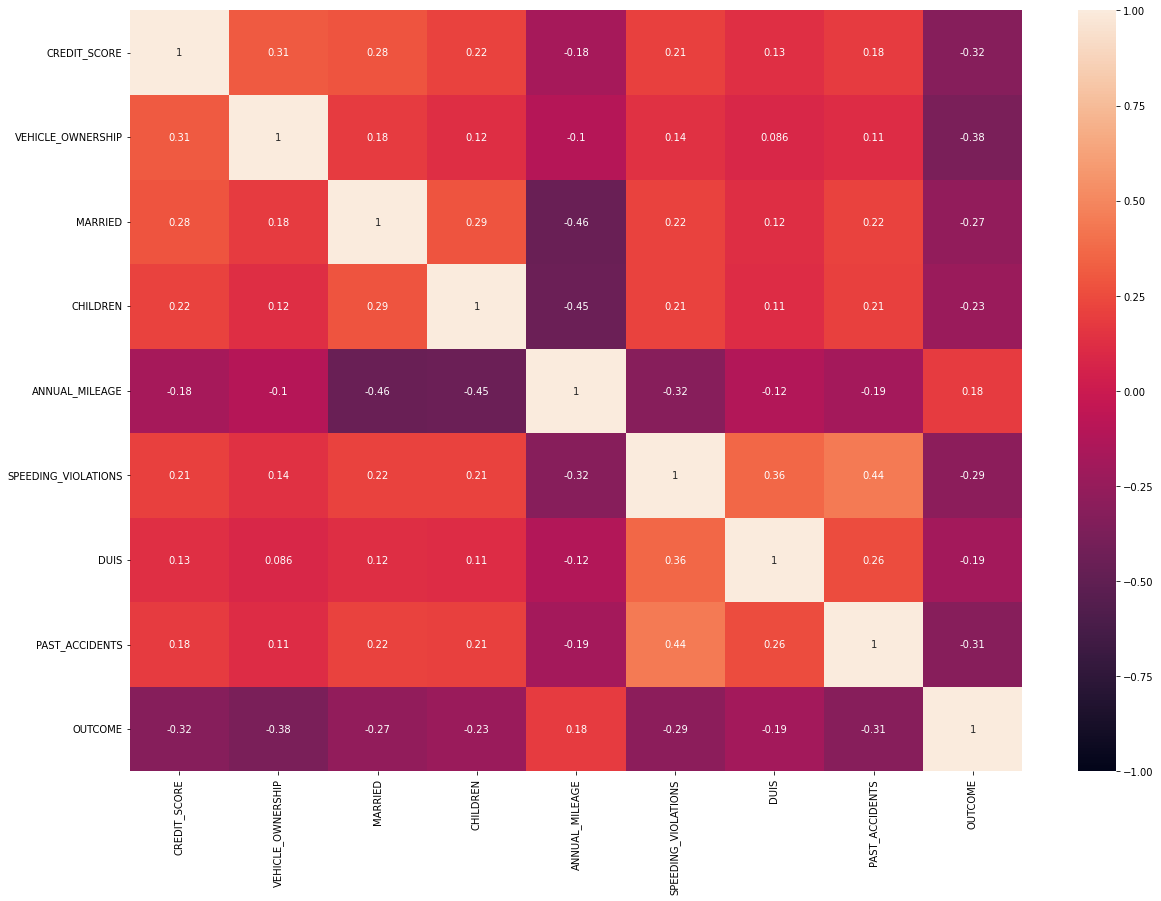

In [120]:
plt.figure(figsize=(20, 14))

sns.heatmap(X.corr(), vmin=-1, vmax=1, annot=True);

## Судя по тепловой карте, коррелированных между собой признаков нет

# Визуализация

## Графики распределения категориальных признаков

#### Стоит рассмотреть как влияют на целевую переменную такие признаки, как VEHICLE_TYPE, POSTAL_CODE и RACE, т.к. они могут не представлять никакой ценности в силу их сильной несбалансированности

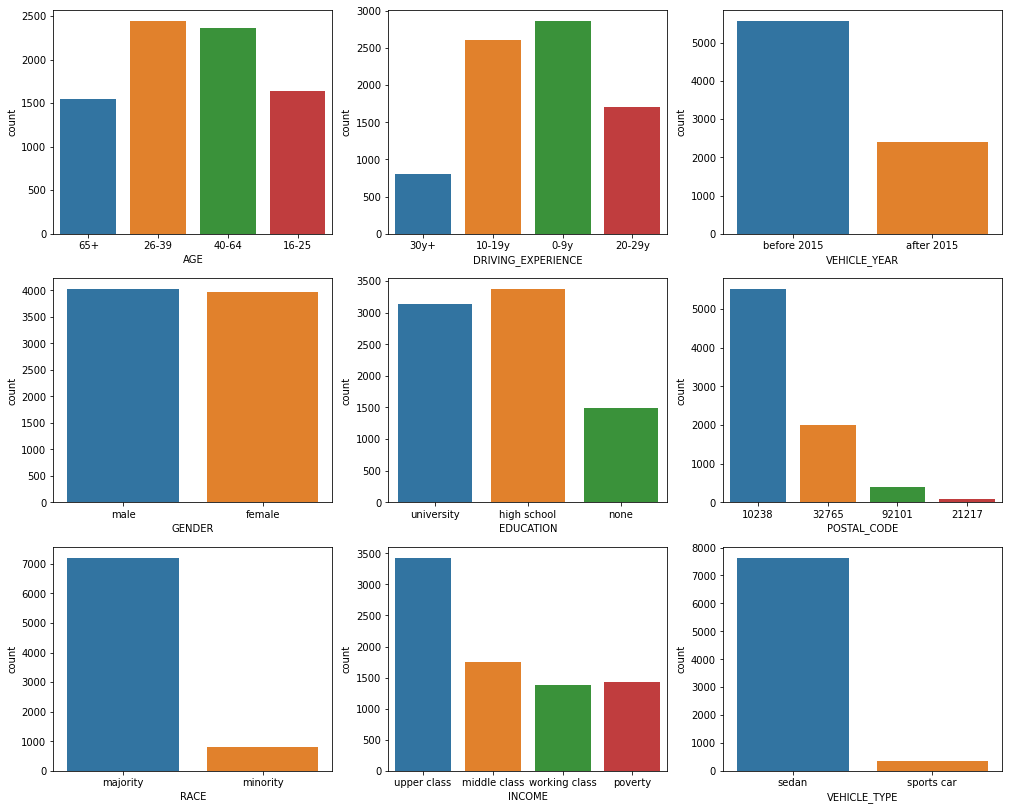

In [121]:
fig, axes = plt.subplots(3,3,figsize=(17,14))

for i, col in enumerate(cat_feats):
    ax = sns.countplot(data=X, x=col, ax=axes[i%3, i//3 ])
#plt.delaxes(axes[2,2])

### Можем увидеть, благодаря сводной таблице, что дизбаланс наблюдается для наблюдений с почтовым индексом = 21217, рассмотрим объекты с соответствующим почтовым индексом

In [122]:
pd.pivot_table(data=X[['RACE', 'OUTCOME']], index='RACE', columns='OUTCOME', aggfunc=lambda x: len(x))

OUTCOME,0.0,1.0
RACE,,
majority,4951,2253
minority,535,261


In [123]:
pd.pivot_table(data=X[['VEHICLE_TYPE', 'OUTCOME']], index='VEHICLE_TYPE', columns='OUTCOME', aggfunc=lambda x: len(x))

OUTCOME,0.0,1.0
VEHICLE_TYPE,,
sedan,5249,2388
sports car,237,126


In [124]:
pd.pivot_table(data=X[['POSTAL_CODE', 'OUTCOME']], index='POSTAL_CODE', columns='OUTCOME', aggfunc=lambda x: len(x))

OUTCOME,0.0,1.0
POSTAL_CODE,,
10238,4030.0,1491.0
21217,NaN,94.0
32765,1227.0,764.0
92101,229.0,165.0


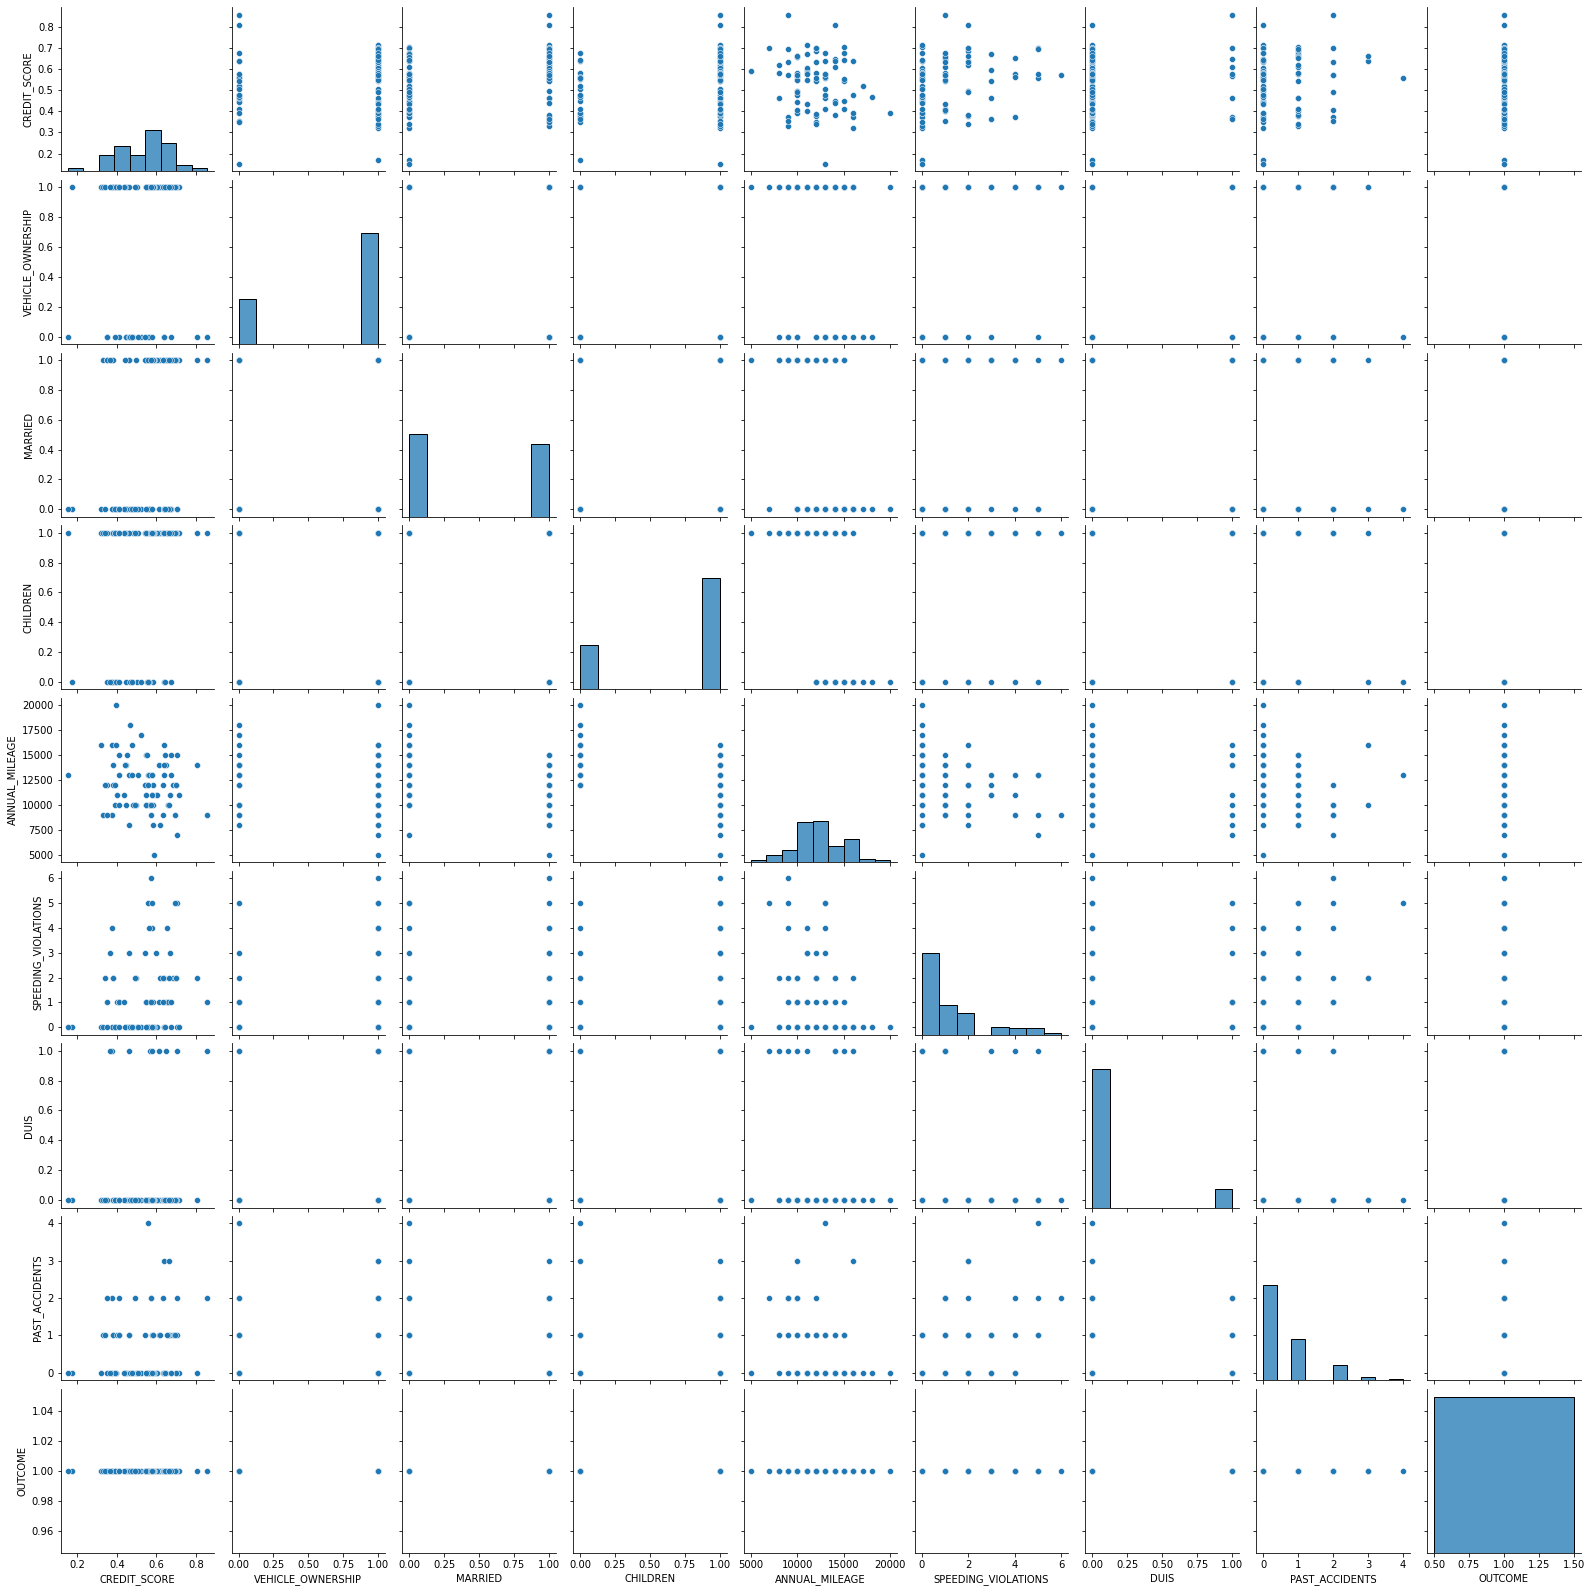

In [125]:
sns.pairplot(X[X['POSTAL_CODE'] == '21217']);

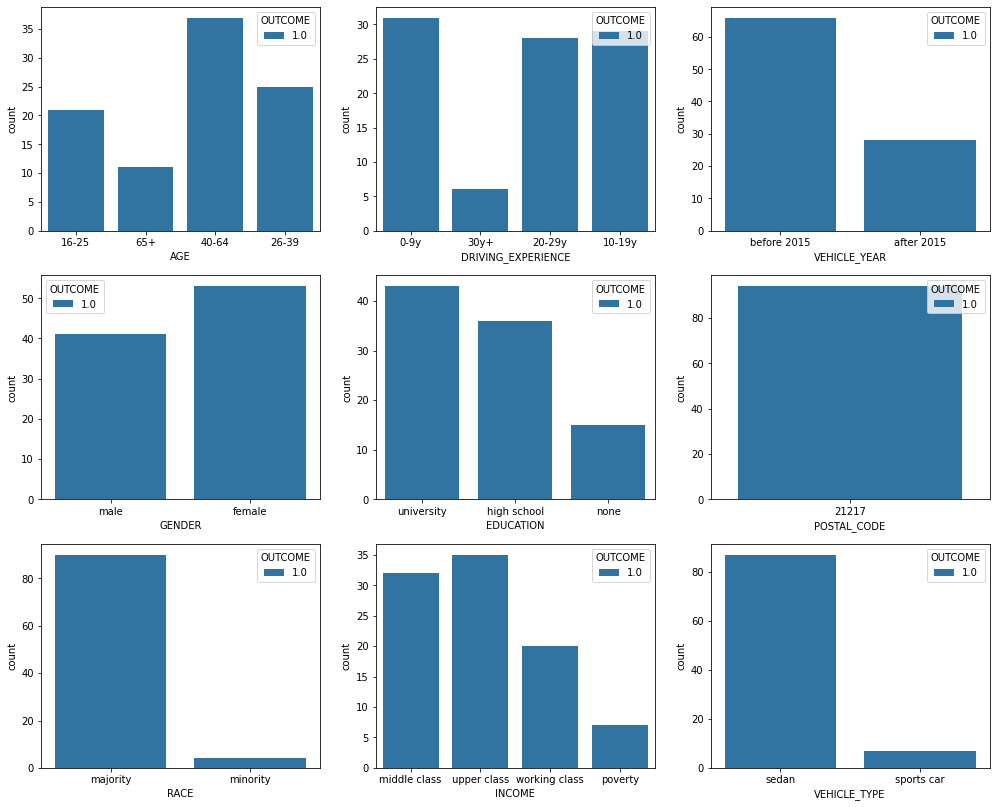

In [126]:
fig, axes = plt.subplots(3,3,figsize=(17,14))

for i, col in enumerate(cat_feats):
    ax = sns.countplot(data=X[X['POSTAL_CODE'] == '21217'], x=col, hue='OUTCOME', ax=axes[i%3, i//3 ])

### Каких-то особенностей, связанных с 21217 почтовым индексом, не наблюдается, посмотрим при обучении модели на какое-либо влияние на предсказание

## Посмотрим на распределение целевой переменной, можем увидеть, что есть дизбаланс, но не сильный (считаем, что нужно прибегать к методам балансировки когда отношение большинства к меньшинству > 10, у нас же отношение = 2.19)

In [127]:
X[X['OUTCOME'] == 0].shape[0] / X[X['OUTCOME'] == 1].shape[0] 

2.1821797931583133

<AxesSubplot:xlabel='OUTCOME', ylabel='count'>

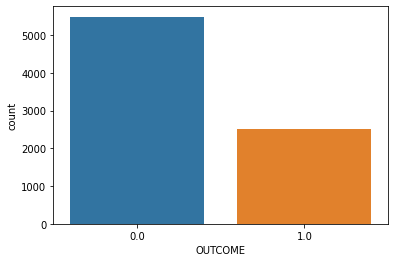

In [128]:
sns.countplot(X['OUTCOME'])

### Рассмотрим те же графики распределения категориальных признаков, но с учетом целевой переменной

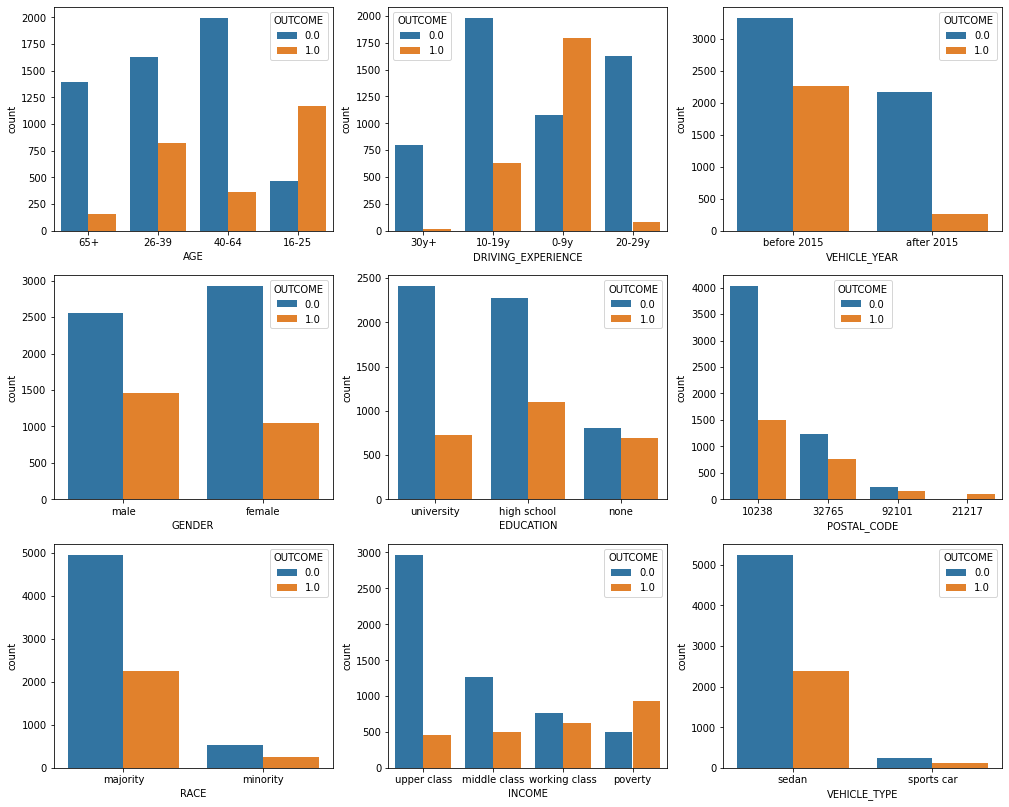

In [129]:
fig, axes = plt.subplots(3,3,figsize=(17,14))

for i, col in enumerate(cat_feats):
    ax = sns.countplot(data=X, x=col, hue='OUTCOME', ax=axes[i%3, i//3 ])

#### - Итак, на первых двух графиках мы можем увидеть, что чем моложе клиент и чем меньше у него опыт вождения, тем чаще он обращается за страховым возмещением(это очень сильно наблюдается, т.к. в "среднем" за страховыми выплатами обращаются меньше чем не обращаются - а на графиках обратное)
#### - Также мы можем увидеть: чем новее машина, тем меньше владелец обращается за страховым возмещением, **но** если машина старше 2015 года, не значит, что клиент обращается чаще за страховкой, тут наблюдается "среднее" поведение
#### - Пол, тип машины, расовая принадлежность и почтовый индекс(с вышеупомянутым исключением) не дают сильной информации об обращении клиента за выплатой
#### - Люди без образования в половине случаев обращаются к фирме за страховым возмещением, это не согласуется с ожидаемым поведением
#### - Бедные люди обращаются за выплатой чаще чем не обращаются, люди из рабочего класса обращаются почти в половине случаев
#### ***- Тут стоит сказать, что все эти зависимости будут учитываться при ван хот энкодинге, поэтому новых фичей генерировать не надо***

# Графики распределения числовых признаков

### 'CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN', 'POSTAL_CODE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS'

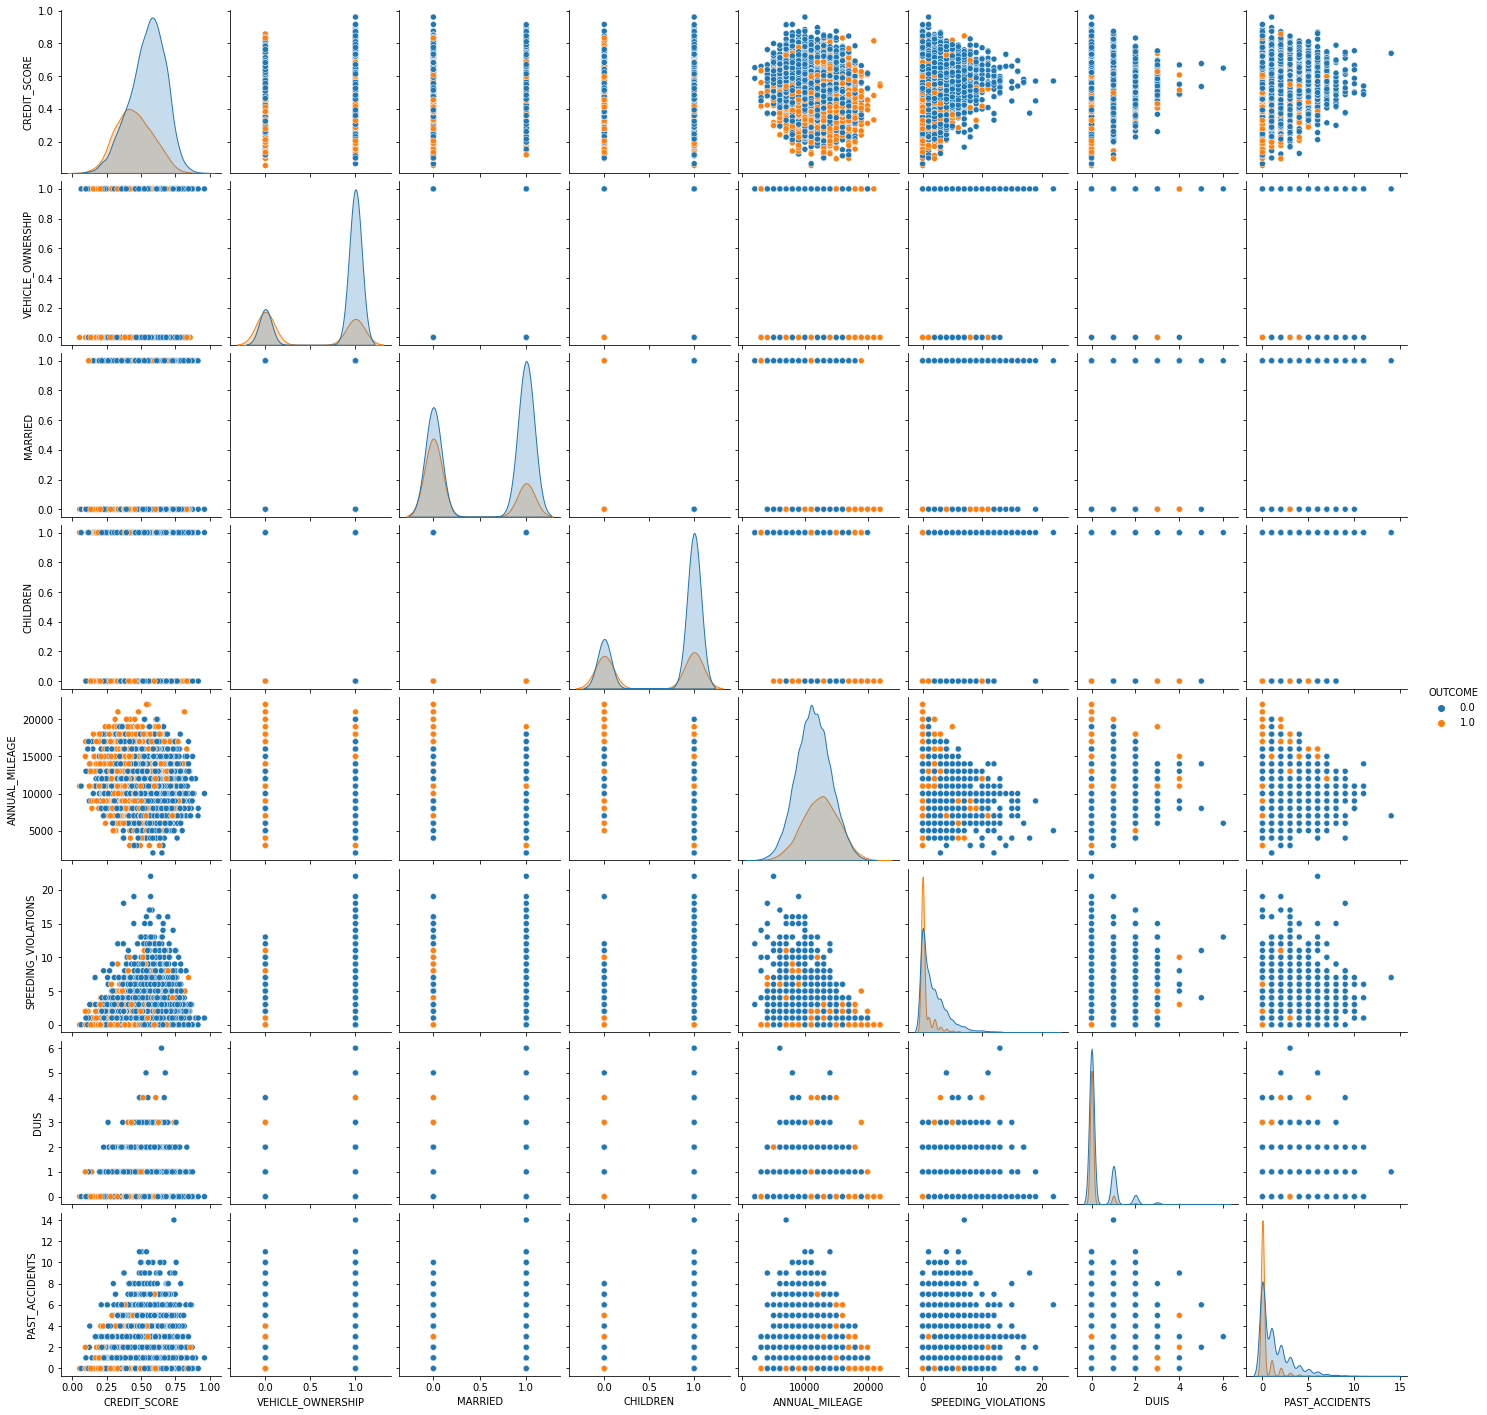

In [130]:
sns.pairplot(X, hue='OUTCOME');

## Ну вроде ничего интересного

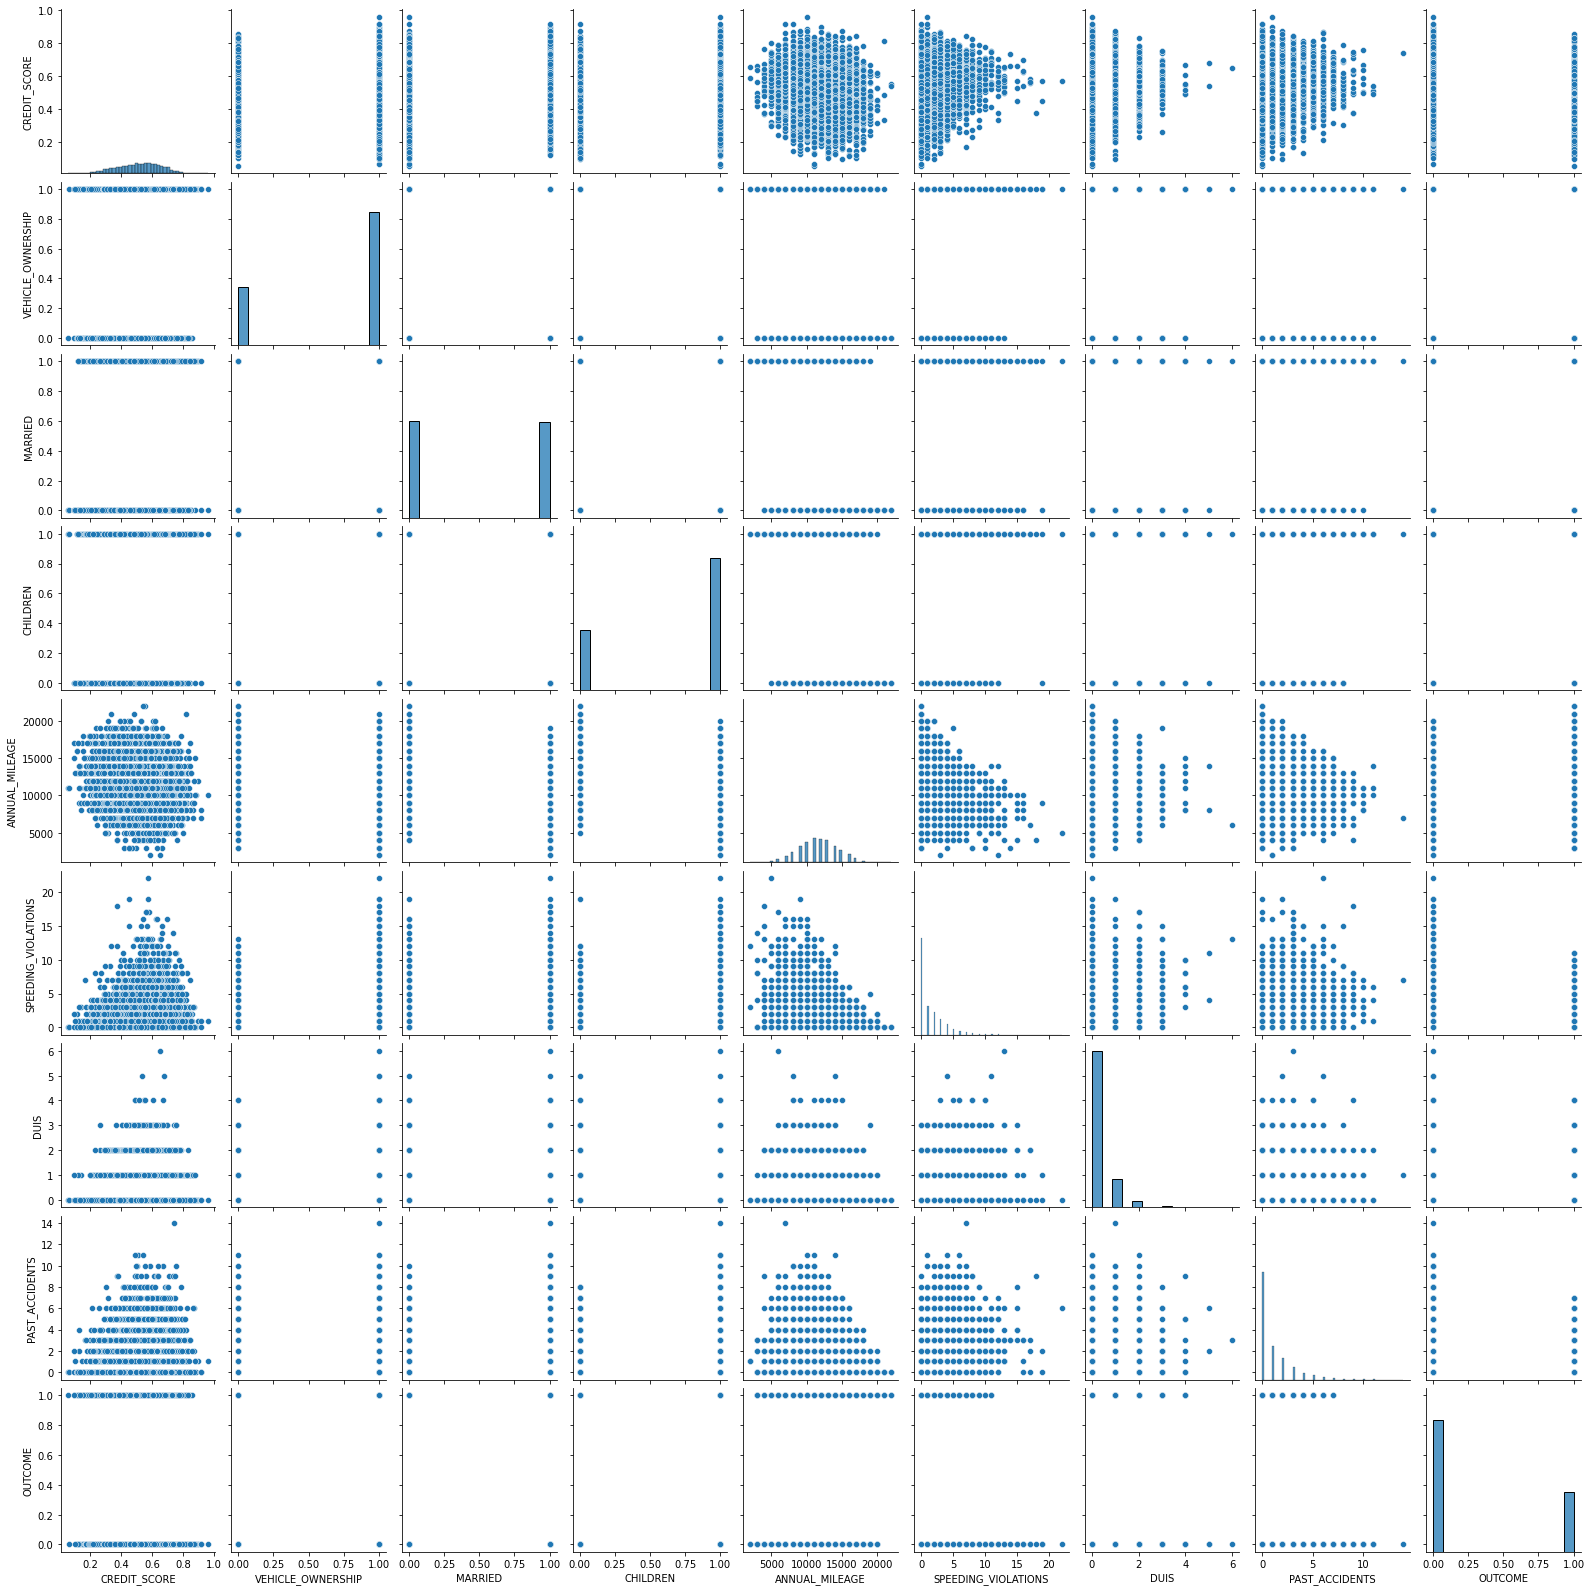

In [131]:
sns.pairplot(X);

### Тут можно заметить, что при достаточно больших значениях признаков 'SPEEDING_VIOLATIONS' и 'PAST_ACCIDETNS' клиент не обращался за страховым возмещением

11

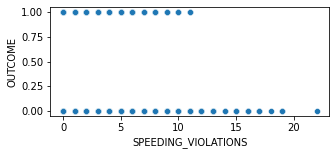

In [132]:
plt.figure(figsize=(5, 2))
sns.scatterplot(x=X['SPEEDING_VIOLATIONS'], y=X['OUTCOME']);
X[X['OUTCOME'] == 1]['SPEEDING_VIOLATIONS'].max()

7

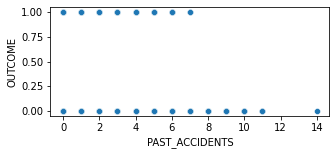

In [133]:
plt.figure(figsize=(5, 2))
sns.scatterplot(x=X['PAST_ACCIDENTS'], y=X['OUTCOME']);
X[X['OUTCOME'] == 1]['PAST_ACCIDENTS'].max()

### Интересно, что пересечение довольно маленькое

In [134]:
print(X[X['SPEEDING_VIOLATIONS'] > 11].shape)
print(X[X['PAST_ACCIDENTS']  > 7].shape)
print(X[(X['SPEEDING_VIOLATIONS'] > 11) & (X['PAST_ACCIDENTS'] > 7)].shape)

(46, 18)
(53, 18)
(2, 18)


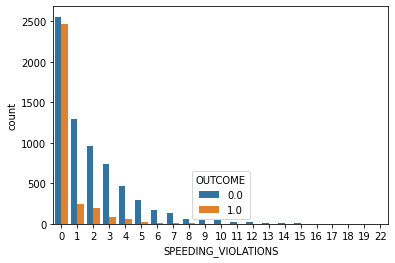

In [135]:
sns.countplot(x=df['SPEEDING_VIOLATIONS'], hue=df['OUTCOME']);

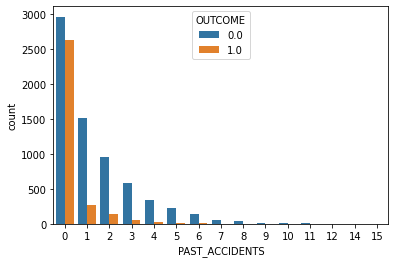

In [136]:
sns.countplot(x=df['PAST_ACCIDENTS'], hue=df['OUTCOME']);

#### - У людей с нулевым 'PAST_ACCIDENT' или 'SPEEDING_VIOLATIONS' очень большой процент обращений за страховым возмещением. Вероятнее всего наблюдаемое распределение при нулевых значениях рассматриваемых признаков связано с тем, что люди, ни разу не попадавшиеся на превышении скорости или не имевшие происшествия на дороге, малоопытны и они с большой вероятностью обратятся за страховым возмещением 
#### - У людей с достаточно большим количеством вышеупомянутых признаков не было необходимости в страховой выплате, все они довольно **многолетние, образованные, обеспеченные и имующие большой опыт вождения**, однако большие нарушители 
#### - **Тут можно составить новые булевые признаки для вышеописанных случаев, для двух случаев с нулевым значением признака и для значений выше соответствующих какому-то порогу, вычисленному выше**
#### *(тут не очень понятна суть признаков, если это данные за всю жизнь, то данные согласуются, т.к. люди высоковозрастные могли получить все эти нарушения в молодом возрасте, иначе - может быть, у них и возникали проблемы на дороге, но случаи не попадали под страховку)*
 

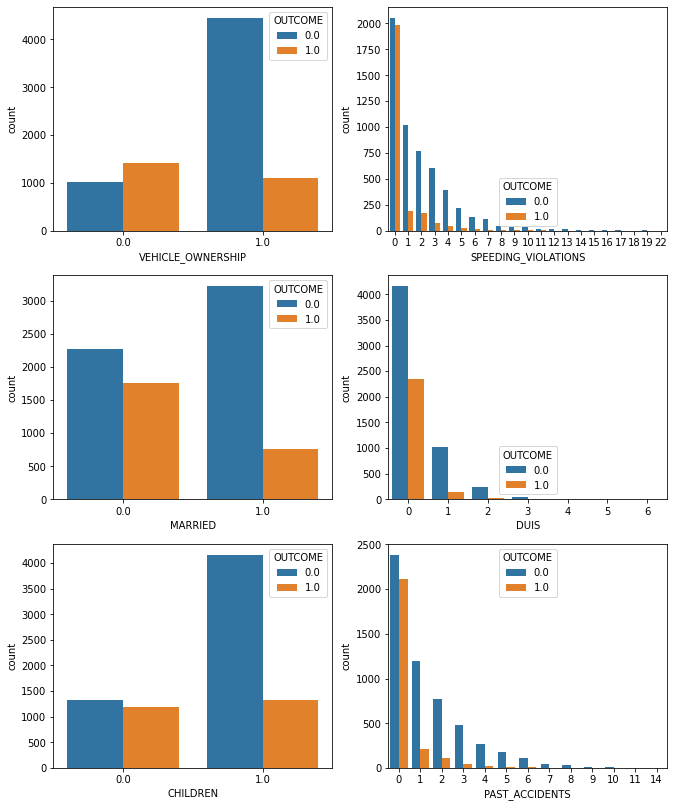

In [137]:
fig, axes = plt.subplots(3,3,figsize=(17,14))
for i, col in enumerate([x for x in num_feats if x not in ['CREDIT_SCORE', 'ANNUAL_MILEAGE']]):
    ax = sns.countplot(data=X, x=col, hue='OUTCOME', ax=axes[i%3, i//3 ])
plt.delaxes(axes[0,2])
plt.delaxes(axes[1,2])
plt.delaxes(axes[2,2])

### Остальные признаки не дают каких-то интересных закономерностей

## Теперь нужно рассмотреть непрерывные числовые признаки : 'CREDIT_SCORE' и 'ANNUAL_MILEAGE'

### На графике видно, что люди с большим кредитным рейтингом меньше обращаются за страховой выплатой 

<AxesSubplot:xlabel='CREDIT_SCORE', ylabel='Count'>

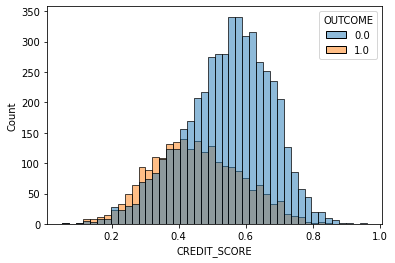

In [138]:
sns.histplot(data=X, x='CREDIT_SCORE', hue='OUTCOME')

### Тут можно увидеть, что с ростом годового пробега растет процент обратившихся за страховым возмещением

<AxesSubplot:xlabel='ANNUAL_MILEAGE', ylabel='Count'>

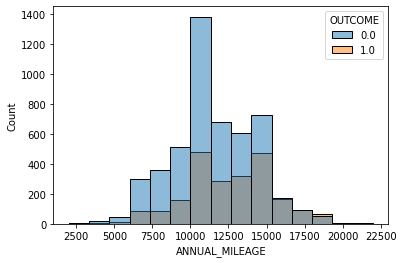

In [139]:
sns.histplot(data=X, x='ANNUAL_MILEAGE', hue='OUTCOME', bins=15)

### График зависящий от трех переменных ('CREDIT_SCORE', 'ANNUAL_MILEAGE', 'OUTCOME') уже был рассмотрен выше в pairplot и не показал значимых зависимостей

## - В итоге нужно сгенерировать 4 новых признака(также проверить их нужность при обучении моделей) и при one hot encoding'e удалить один столбец из значения 'POSTAL_CODE'


# Заполнение пропусков с помощью KNNRegressor

In [140]:
from sklearn.neighbors import KNeighborsRegressor

In [141]:
X_without_nan = X[np.logical_not(X['CREDIT_SCORE'].isna()) & 
                  np.logical_not(X['ANNUAL_MILEAGE'].isna())][num_feats]

In [142]:
knn_for_creditscore = KNeighborsRegressor()

knn_for_creditscore.fit(X_without_nan.drop(['CREDIT_SCORE', 'ANNUAL_MILEAGE'], axis=1),
                        X_without_nan['CREDIT_SCORE'])

KNeighborsRegressor()

In [143]:
knn_for_annualmileg = KNeighborsRegressor()

knn_for_annualmileg.fit(X_without_nan.drop(['CREDIT_SCORE', 'ANNUAL_MILEAGE'], axis=1),
                        X_without_nan['ANNUAL_MILEAGE']);

In [144]:
def handle_credit_score_nans(X):
    X_cr_sc_nans = X[X.CREDIT_SCORE.isna()]
    X_out = X.drop(X_cr_sc_nans.index)
    fillings = knn_for_creditscore.predict(X_cr_sc_nans[num_feats].drop(['CREDIT_SCORE', 'ANNUAL_MILEAGE'],
                                                                        axis=1))
    X_cr_sc_nans['CREDIT_SCORE'] = fillings
    X_out = pd.concat([X_out, X_cr_sc_nans])
    return X_out

def handle_annual_mileage_nans(X):
    X_an_mil_nan = X[X.ANNUAL_MILEAGE.isna()]
    X_out = X.drop(X_an_mil_nan.index)
    fillings = knn_for_annualmileg.predict(X_an_mil_nan[num_feats].drop(['CREDIT_SCORE', 'ANNUAL_MILEAGE'],
                                                                        axis=1))
    X_an_mil_nan['ANNUAL_MILEAGE'] = fillings
    X_out = pd.concat([X_out, X_an_mil_nan])
    return X_out

In [145]:
X = handle_credit_score_nans(X)
X = handle_annual_mileage_nans(X)

X_test = handle_credit_score_nans(X_test)
X_test = handle_annual_mileage_nans(X_test)

### Теперь feature engineering

In [146]:
X['SPEEDING_VIOLATIONS_IS_0'] = X['SPEEDING_VIOLATIONS'] == 0
X['PAST_ACCIDENTS_IS_0'] = X['PAST_ACCIDENTS'] == 0
X['SPEEDING_VIOLATIONS_GR_11'] = X['SPEEDING_VIOLATIONS'] > 11
X['PAST_ACCIDENTS_GR_7'] = X['PAST_ACCIDENTS'] > 7

# Думаю целесообразно еще заменить числа большие соответствующего их столбцам порога заменить на 0
change_speed_viols = np.vectorize(lambda x: 0 if x > 11 else x)
change_past_accids = np.vectorize(lambda x: 0 if x > 7 else x)
X['SPEEDING_VIOLATIONS'] = change_speed_viols(X['SPEEDING_VIOLATIONS'])
X['PAST_ACCIDENTS'] = change_past_accids(X['PAST_ACCIDENTS'])

# Делаем то же, но для тестовой выборки
X_test['SPEEDING_VIOLATIONS_IS_0'] = X_test['SPEEDING_VIOLATIONS'] == 0
X_test['PAST_ACCIDENTS_IS_0'] = X_test['PAST_ACCIDENTS'] == 0
X_test['SPEEDING_VIOLATIONS_GR_11'] = X_test['SPEEDING_VIOLATIONS'] > 11
X_test['PAST_ACCIDENTS_GR_7'] = X_test['PAST_ACCIDENTS'] > 7

X_test['SPEEDING_VIOLATIONS'] = change_speed_viols(X_test['SPEEDING_VIOLATIONS'])
X_test['PAST_ACCIDENTS'] = change_past_accids(X_test['PAST_ACCIDENTS'])

# Работа над категориальными признаками с помощью OneHotEncoder

In [147]:
ohe = OneHotEncoder(drop='if_binary', sparse=False, handle_unknown='ignore')
ohe.fit(X[cat_feats]);

In [148]:
ohe.get_feature_names()

array(['x0_16-25', 'x0_26-39', 'x0_40-64', 'x0_65+', 'x1_male',
       'x2_minority', 'x3_0-9y', 'x3_10-19y', 'x3_20-29y', 'x3_30y+',
       'x4_high school', 'x4_none', 'x4_university', 'x5_middle class',
       'x5_poverty', 'x5_upper class', 'x5_working class',
       'x6_before 2015', 'x7_10238', 'x7_21217', 'x7_32765', 'x7_92101',
       'x8_sports car'], dtype=object)

In [149]:
def one_hot_enc(X, cols_for_ohe=None):
    flag = 0
    X_out = X.copy()
    if 'OUTCOME' in X_out.columns:
        outcome = X_out['OUTCOME']
        X_out = X_out.drop('OUTCOME', axis=1)
        flag = 1
    new_cols = pd.DataFrame(ohe.transform(X_out[cols_for_ohe]), index=X_out.index, columns=ohe.get_feature_names())
    X_out = pd.concat([X_out.drop(cols_for_ohe, axis=1), new_cols], axis=1)
    if flag:
        X_out = pd.concat([X_out, outcome], axis=1)
    return X_out

In [150]:
X = one_hot_enc(X, cat_feats)
X_test = one_hot_enc(X_test, cat_feats)

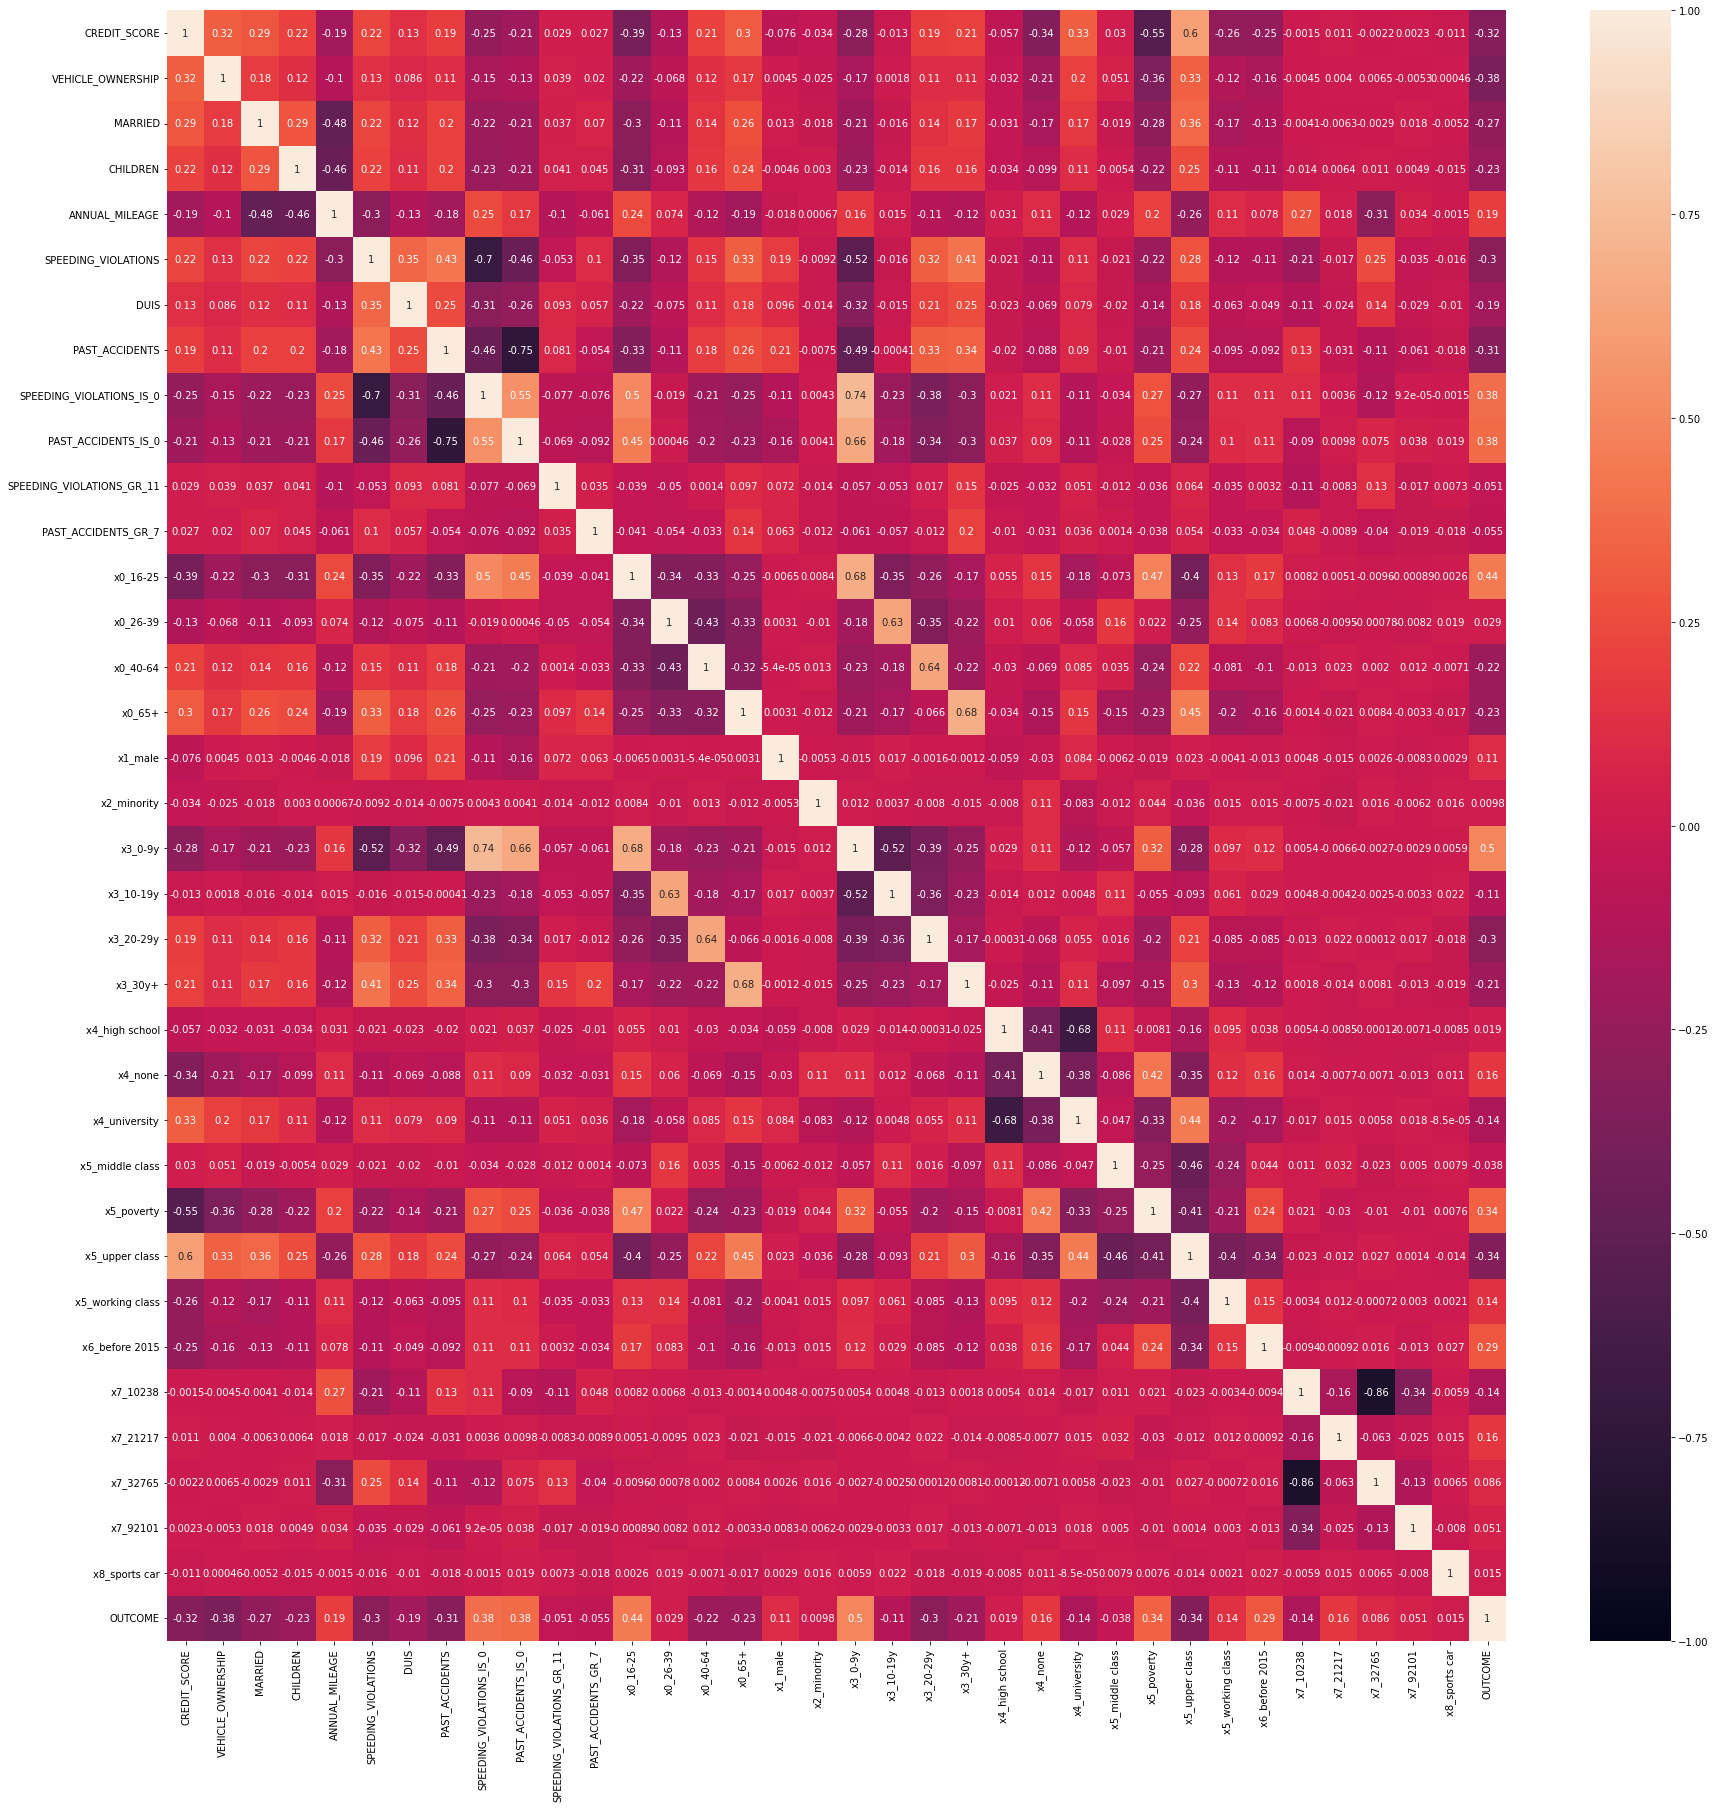

In [151]:
plt.figure(figsize=(30, 30))
          
sns.heatmap(X.corr(), vmin=-1, vmax=1, annot=True);

### Теперь нужно поработать с коррелированными признаками
### - x3_0-9y коррелирует сразу с тремя признаками, также есть очень большая связь между x7_10238 и x7_32765
### - Есть еще сильные корреляции между признаками 'PAST_ACCIDENTS', 'SPEEDING_VIOLATIONS' и их производными признаками, но их мы не будем трогать, т.к. есть обоснованность, из-за которых и были созданы производные признаки
### - На корреляцию между производными от 'EDUCATION' признаками можем не обращать внимание, т.к. нет сильной логической связи (был бы смысл, если корреляция тут была положительная, т.е. окончанию высшей школы следовало бы окончание университета, у нас же большая отрицательная корреляция)
### - Следовало бы рассмотреть влияние на предсказание модели признаков возраста, т.к. они коррелируют с соответственными признаками опыта вождения, но тут нет логической связи, большой возраст не говорит о большом опыте вождения ( я рассмотрел, результаты хуже )

In [152]:
cols_for_drop = ['x3_0-9y', 'x7_10238', 'x7_21217']

X = X.drop(cols_for_drop, axis=1)
X_test = X_test.drop(cols_for_drop, axis=1)

# Масштабирование
### - Масшатабирование будет только для линейной модели, я включу ее в конвейер, т.к. модель будет проверяться через кросс-валидацию, а обучать масштабирование надо на данных, которые не попали в валидационную выборку

----------------------------------------------------

# На этом пока закончиваем работу над признаками и начинаем поиск модели
## - Возьмем 3 модели: SGDClassifier, RandomForestClassifier, XGBClassifier
## - Сравнивать будем по метрикам: accuracy, f1_score, roc_auc_score, precision_score, recall_score, log_loss
## Страховая компания не имеет права отказывать в заключении договора о страховании, так что нет явной цели задачи (нельзя понять, что важнее precision или recall), даже если бы у компании было право отказывать, то задача была бы по сути кредитным скорингом, а тут все зависило бы от периодных страховых взносов, если они достаточно большие, то нам важнее была бы метрика precision, т.к. мы можем страховать клиентов с некоторым риском, ведь доходы от взносов покроют страховые возмещения

In [153]:
X, y = X.drop('OUTCOME', axis=1), X['OUTCOME'],
X_test, y_test = X_test.drop('OUTCOME', axis=1), X_test['OUTCOME']

In [154]:
def estimate_preds(y_true, y_pred, y_probs):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_probs)
    log_loss_ = log_loss(y_true, y_probs)
    precision_ = precision_score(y_true, y_pred)
    recall_ = recall_score(y_true, y_pred)
    return acc, f1, roc_auc, precision_, recall_, log_loss_

preds_of_models = {}

# -----------------------SGDClassifier---------------------------

In [155]:
params_for_sgd_clf = {
    'clf__max_iter': [1000, 5000, 10000],
    'clf__loss': ['log', 'hinge'],
    'clf__eta0': [0.01, 0.001, 0.0001, 0.00003]
}

sgd_clf = SGDClassifier(learning_rate='adaptive', random_state=52, n_jobs=-1)
std_scal = ColumnTransformer(transformers=[('num', StandardScaler(), ['ANNUAL_MILEAGE'])],
                             remainder='passthrough')

sgd_clf_with_std_scal = Pipeline(steps=[('preproc', std_scal),
                                ('clf', sgd_clf)])

In [156]:
grid_search_sgd_clf = GridSearchCV(sgd_clf_with_std_scal,
                            param_grid=params_for_sgd_clf,
                            cv=5,
                            scoring='roc_auc',
                            )

grid_search_sgd_clf.fit(X, y);

preds_of_models['sgd_clf_with_std_scal'] = estimate_preds(
                                                        y_test,
                                    grid_search_sgd_clf.predict(X_test),
                                    grid_search_sgd_clf.predict_proba(X_test)[:, 1]
                                            )

In [157]:
estimate_preds(y_test, grid_search_sgd_clf.predict(X_test),
               grid_search_sgd_clf.predict_proba(X_test)[:, 1]
               )

(0.841,
 0.7215411558669003,
 0.9036099195287065,
 0.7877629063097514,
 0.6655896607431341,
 0.359583308127434)

# ----------------------RANDOM_FOREST-----------------------------

In [158]:
losses_random_forest = {}
best_score = None
best_random_forest = None


for min_simple_leaf_ in [3, 5, 7]:
    for max_features_ in ['log2', 'sqrt', ]:
        losses_for_params = []
        for i in tqdm(range(100,1501, 50)):
            random_frst_clf = RandomForestClassifier(n_estimators=i, random_state=42, n_jobs=-1,
                                             max_features=max_features_, min_samples_leaf=min_simple_leaf_)
            random_frst_clf.fit(X, y)
            result = log_loss(y_test,
                                   random_frst_clf.predict_proba(X_test)[:, 1])
            if best_score is None or  result < best_score:
                best_score = result
                best_random_forest = random_frst_clf
            losses_for_params.append(result)
        losses_random_forest[f'{min_simple_leaf_} '+ 'min_samples_leaf ' +
                             max_features_ + ' max_features'] = losses_for_params

100%|██████████| 29/29 [01:46<00:00,  3.66s/it]


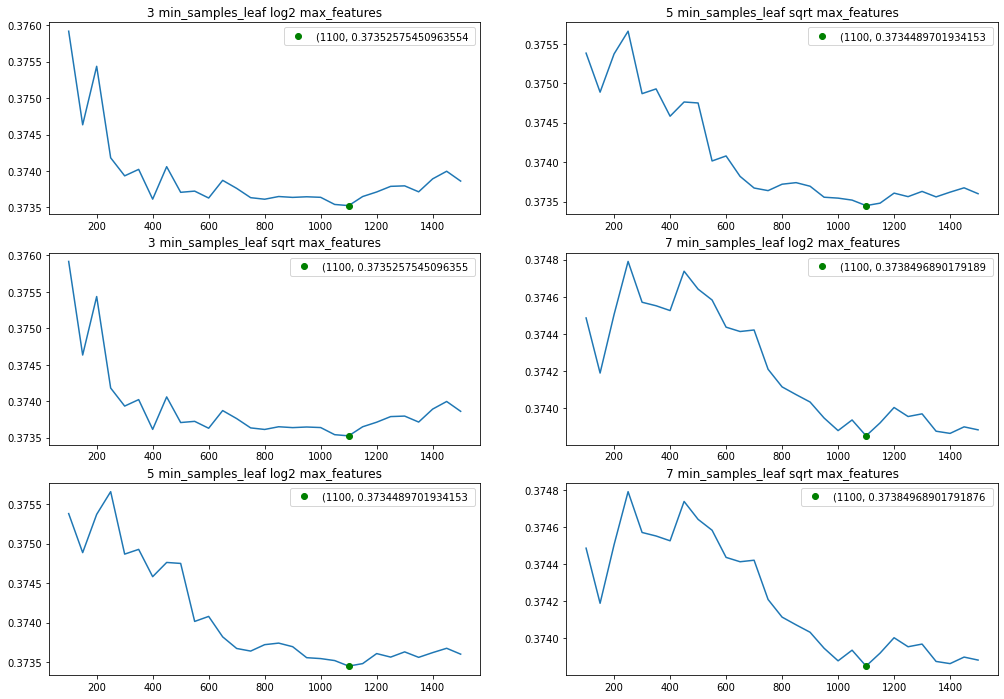

In [159]:
fig, axes = plt.subplots(3, 2, figsize=(17, 12))

losses_for_plots = losses_random_forest
x_axis = list(range(100,1501, 50))

for i, (key, value) in enumerate(losses_for_plots.items()):
    value = np.array(value)
    axes[i%3, i//3].plot(x_axis,value)
    axes[i%3, i//3].plot(x_axis[value.argmin()],
                          value[value.argmin()], 'go',
                         label=f'({x_axis[value.argmin()]}, {value.min()} ')
    axes[i%3, i//3].legend()
    axes[i%3, i//3].set_title(key)

In [160]:
preds_of_models['random_forest'] = estimate_preds(y_test,
               best_random_forest.predict(X_test), 
               best_random_forest.predict_proba(X_test)[:, 1])

In [161]:
estimate_preds(y_test, best_random_forest.predict(X_test), 
               best_random_forest.predict_proba(X_test)[:, 1])

(0.8405,
 0.7242869490060502,
 0.8950258469723539,
 0.7788104089219331,
 0.6768982229402262,
 0.3734489701934153)

# ----------------------GRADIENT_BOOSTING-----------------------

In [162]:
losses_grad_boosting = {}
best_score_gr_boost = None
best_grad_boost = None
print(2 * 3 * 2 * 3)
for sampling_method in ['uniform', 'gradient_based']:
    for learning_rate in [0.1, 0.01, 0.001]:
        for subsample in [0.3, 0.6]:
            for max_depth in [2, 3, 5]:
                losses_for_params = []
                for i in tqdm(range(100,1501, 50)):
                    clf_boost = XGBClassifier(n_estimators=i, max_depth=max_depth, subsample=subsample,
                                            learning_rate=learning_rate, n_jobs=-1, random_state=100)
                    clf_boost.fit(X, y)
                    result = log_loss(y_test, clf_boost.predict_proba(X_test)[:, 1])

                    if best_score_gr_boost is None or result < best_score_gr_boost:
                        best_score_gr_boost = result
                        best_grad_boost = clf_boost
                    losses_for_params.append(result)
                losses_grad_boosting[
                    'sampl_mtd: ' + sampling_method +
                    f' lr: {learning_rate}, subsample: {subsample}, max_depth: {max_depth}'
                ] = losses_for_params

36


100%|██████████| 29/29 [02:45<00:00,  5.72s/it]


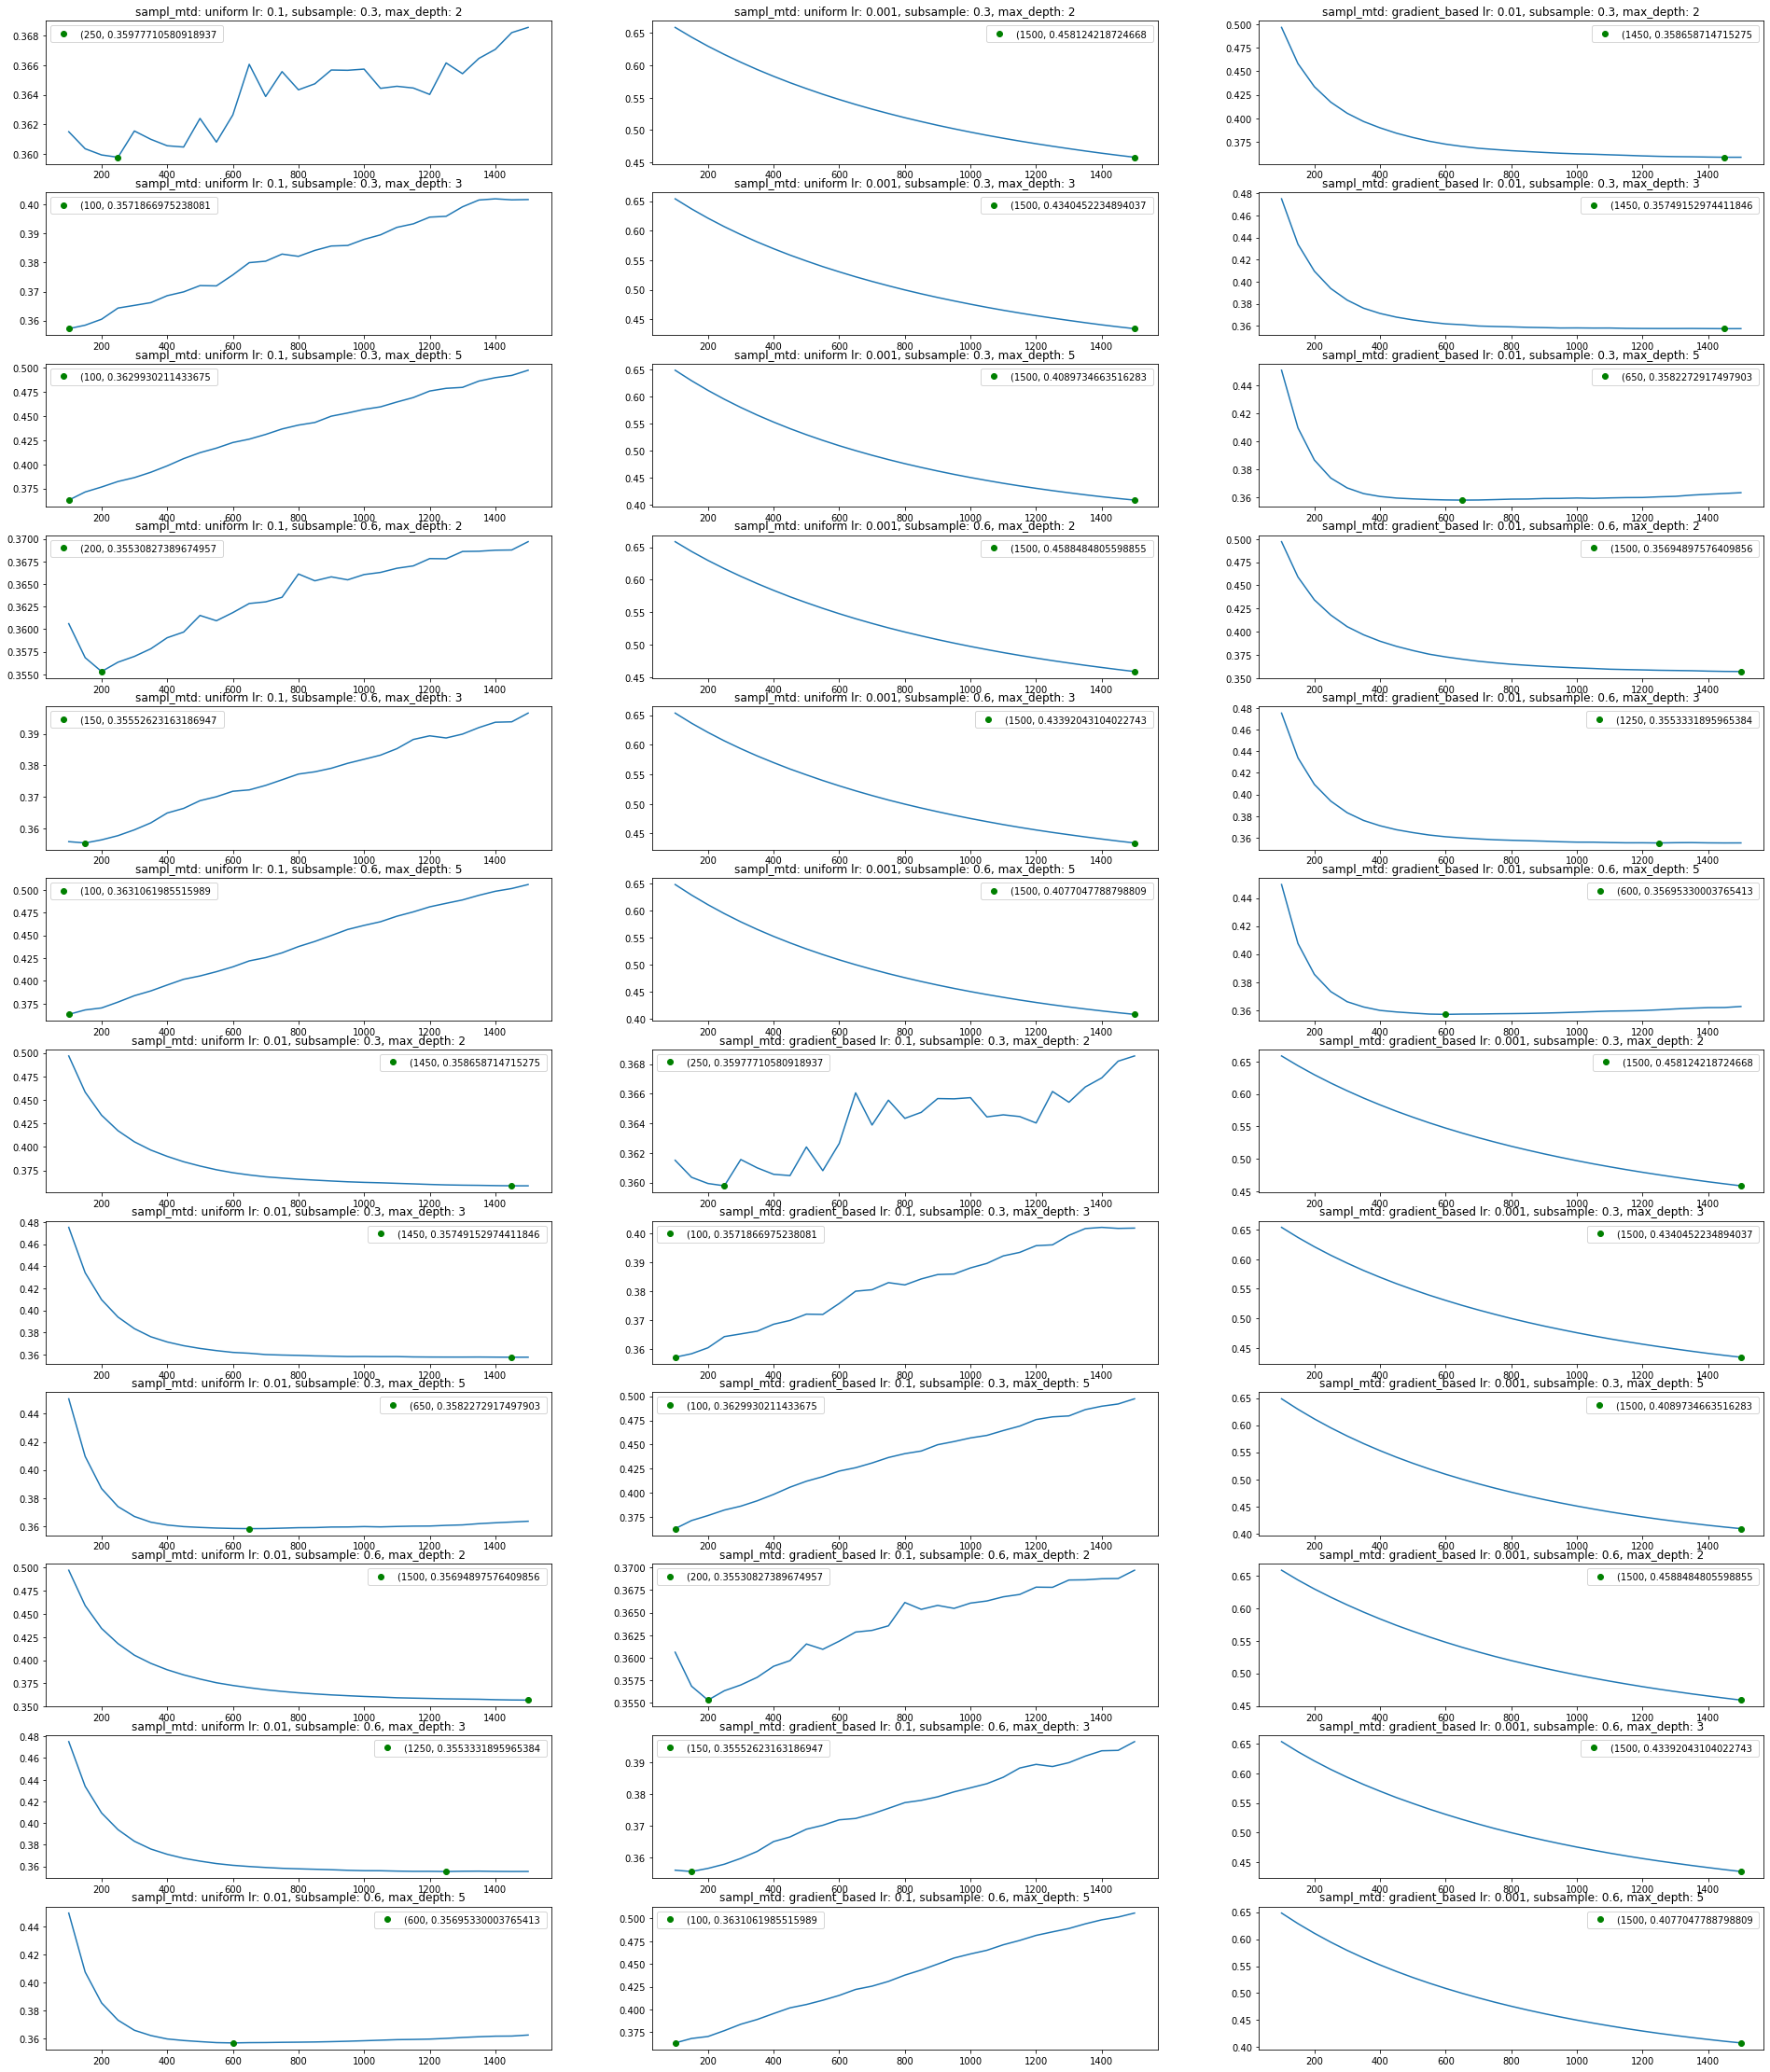

In [163]:
fig, axes = plt.subplots(12, 3, figsize=(33, 40))

losses_for_plots1 = losses_grad_boosting
x_axis = list(range(100,1501, 50))

for i, (key, value) in enumerate(losses_for_plots1.items()):
    value = np.array(value)
    axes[i%12, i//12].plot(x_axis,value)
    axes[i%12, i//12].plot(x_axis[value.argmin()],
                          value[value.argmin()], 'go',
                         label=f'({x_axis[value.argmin()]}, {value.min()} ')
    axes[i%12, i//12].legend()
    axes[i%12, i//12].set_title(key)

In [164]:
best_grad_boost.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 2,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 200,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 100,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 0.6,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [165]:
estimate_preds(y_test, best_grad_boost.predict(X_test),
               best_grad_boost.predict_proba(X_test)[:, 1]
                )

(0.8425,
 0.7296137339055796,
 0.9053897868487516,
 0.7783882783882784,
 0.6865912762520194,
 0.35530827389674957)

# Некоторые итоги о gradient boosting
###  Лучше всего с задачей справляется gradient_boosting; лучший результат у модели {n_estimators=200, max_depth=2, sampling_method='uniform', learning_rate=0.1, subsample=0.6}, но график кажется нестабильным, я поэкспериментирую с learning_rate, subsample и возьму базовые модели с max_depth=3

In [166]:
losses_3_max_depth = []
best_score_gr_bst_3_dpth = None
best_gr_bst_3_dpth = None
losses_gr_boost_3_dpth = {}

for learning_rate in [0.07, 0.1]:
    for subsample in [0.5, 0.6]:
        losses_for_params = []
        for i in tqdm(range(50, 401, 10)):
            gr_boost_3_dpth = XGBClassifier(n_estimators=i, max_depth=3, subsample=subsample,
                                            learning_rate=learning_rate, n_jobs=-1, random_state=100)
            gr_boost_3_dpth.fit(X, y)
            result = log_loss(y_test, gr_boost_3_dpth.predict_proba(X_test)[:, 1])
            
            if best_score_gr_bst_3_dpth is None or  result < best_score_gr_bst_3_dpth:
                best_score_gr_bst_3_dpth = result
                best_gr_bst_3_dpth = gr_boost_3_dpth
            losses_for_params.append(result)
        losses_gr_boost_3_dpth[
            f'l_r: {learning_rate}, subsample: {subsample}, max_depth: 3'
                            ] = losses_for_params

100%|██████████| 36/36 [00:41<00:00,  1.16s/it]


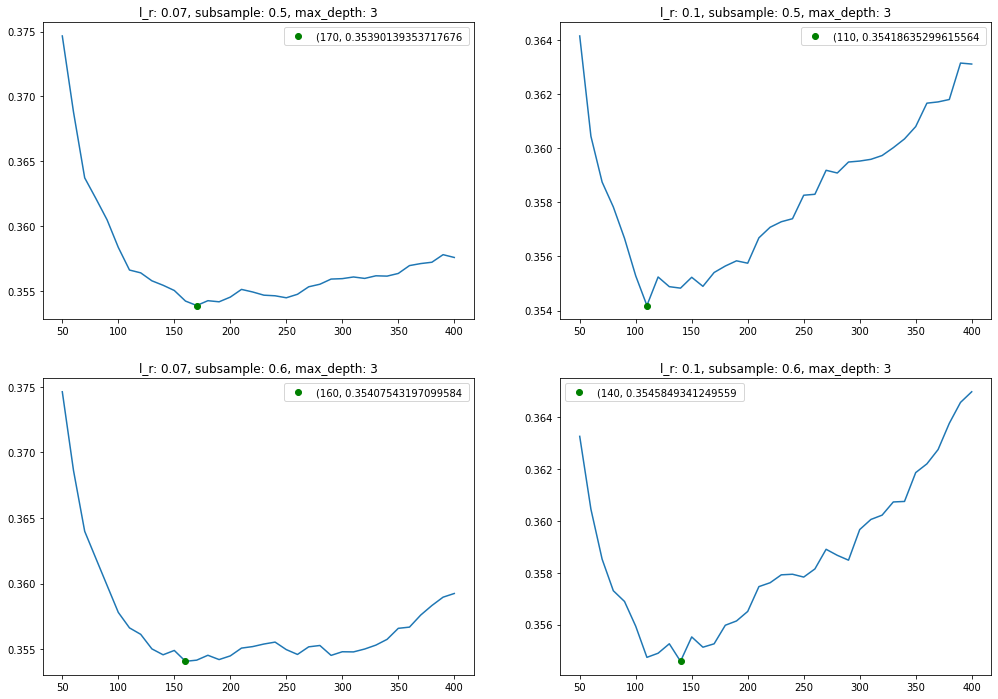

In [167]:
fig, axes = plt.subplots(2, 2 , figsize=(17, 12))

losses_for_plots2 = losses_gr_boost_3_dpth
x_axis = list(range(50,401, 10))

for i, (key, value) in enumerate(losses_for_plots2.items()):
    value = np.array(value)
    axes[i%2, i//2].plot(x_axis, value)
    axes[i%2, i//2].plot(x_axis[value.argmin()],
                          value[value.argmin()], 'go',
                         label=f'({x_axis[value.argmin()]}, {value.min()} ')
    axes[i%2, i//2].legend()
    axes[i%2, i//2].set_title(key)

In [168]:
preds_of_models['gradient_boosting'] = estimate_preds(y_test,
                            best_gr_bst_3_dpth.predict(X_test),
                            best_gr_bst_3_dpth.predict_proba(X_test)[:, 1]
                            )

In [169]:
preds_of_models

{'sgd_clf_with_std_scal': (0.841,
  0.7215411558669003,
  0.9036099195287065,
  0.7877629063097514,
  0.6655896607431341,
  0.359583308127434),
 'random_forest': (0.8405,
  0.7242869490060502,
  0.8950258469723539,
  0.7788104089219331,
  0.6768982229402262,
  0.3734489701934153),
 'gradient_boosting': (0.848,
  0.7414965986394557,
  0.9060419564385809,
  0.7827648114901257,
  0.7043618739903069,
  0.35390139353717676)}

## Ну вот и все, итоговая модель XGBClassifier(n_estimators=170, max_depth=3, learning_rate=0.07, subsample=0.5)